In [1]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, Table, MetaData, insert, select, func, desc
from datetime import datetime

plt.style.use('ggplot')

# connect to database & reflect tables

In [2]:
# Define an engine to connect sqlite database
engine = create_engine('sqlite:///hawaii.sqlite')

In [3]:
# Define metadata, connection to execute query from the database
metadata = MetaData()
connection = engine.connect()

In [4]:
# Reflect both tables from the engine
measurement = Table('measurement', metadata, autoload=True, autoload_with=engine)
station = Table('station', metadata, autoload=True, autoload_with=engine)

# precipitation analysis

In [5]:
# Build an expression to calculate the sum of prcp labeled as precipitation
prcp_sum = func.sum(measurement.columns.prcp).label('precipitation')

# Build a query to select the date and mean of prcp
stmt = select([measurement.columns.date, prcp_sum])

# Group stmt by state
stmt = stmt.group_by(measurement.columns.date)

# filter By date
stmt = stmt.where(measurement.columns.date > '2016-08-31')

print(stmt)

SELECT measurement.date, sum(measurement.prcp) AS precipitation 
FROM measurement 
WHERE measurement.date > :date_1 GROUP BY measurement.date


In [6]:
# Execute the statement
results = connection.execute(stmt).fetchall()

In [7]:
# Create a DataFrame from the results: df
df = pd.DataFrame(results)

# Set column names
df.columns = results[0].keys()

In [8]:
# convert date from string to time series
time_series = []
for i in range(len(df)):
        date = datetime.strptime(df['date'][i], "%Y-%m-%d")
        time_series.append(date)

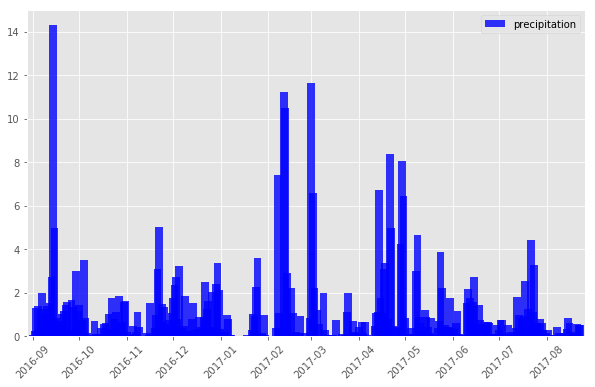

In [9]:
# plot the precipitation data of last 12 months
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.bar(time_series, df['precipitation'], width=5, label='precipitation',
       color='blue', alpha=0.8)
ax.xaxis_date()
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.xlim(pd.Timestamp('2016-8-28'), pd.Timestamp('2017-8-26'))
plt.show()

In [10]:
# print out statistics of the precipitation, including mean, max, min & different percentiles
df['precipitation'].describe()

count    357.000000
mean       0.945294
std        1.731066
min        0.000000
25%        0.050000
50%        0.390000
75%        1.070000
max       14.280000
Name: precipitation, dtype: float64

# Station analysis

## Design a query to calculate the total number of stations.

In [11]:
# Build a query to count the distinct station values
stmt = select([func.count(station.columns.station.distinct())])

# Execute the query and store the scalar result: distinct_state_count
distinct_station_count = connection.execute(stmt).scalar()

# Print the results
print(distinct_station_count)

9


## Design a query to find the most active stations.

In [12]:
# Build an expression to calculate the count of observations as observation_count
ob_count = func.count(measurement.columns.prcp).label('observation_count')

# Build a query to select the date and mean of prcp
stmt = select([measurement.columns.station, ob_count])

# Group stmt by state
stmt = stmt.group_by(measurement.columns.station)

# Order stmt by observation_count in descending order: rev_stmt
rev_stmt = stmt.order_by(desc(ob_count))

print(rev_stmt)

SELECT measurement.station, count(measurement.prcp) AS observation_count 
FROM measurement GROUP BY measurement.station ORDER BY observation_count DESC


In [13]:
# Execute the statement
results = connection.execute(rev_stmt).fetchall()

In [14]:
# print the results
for result in results:
    print(result)

print("----------")
print(f"The most active station is {results[0][0]}, with {results[0][1]} of observations.")

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)
----------
The most active station is USC00519281, with 2772 of observations.


## Design a query to retrieve the last 12 months of temperature observation data (tobs)

In [15]:
# Build a query to select the tobs
stmt = select([measurement.columns.tobs])

# filter stmt by station
stmt = stmt.where(measurement.columns.station == "USC00519281")

# filter By date
stmt = stmt.where(measurement.columns.date > '2016-08-31')

print(stmt)

SELECT measurement.tobs 
FROM measurement 
WHERE measurement.station = :station_1 AND measurement.date > :date_1


In [16]:
# Execute the statement
results = connection.execute(stmt).fetchall()

In [17]:
# Create a DataFrame from the results: df
df = pd.DataFrame(results)

# Set column names
df.columns = results[0].keys()

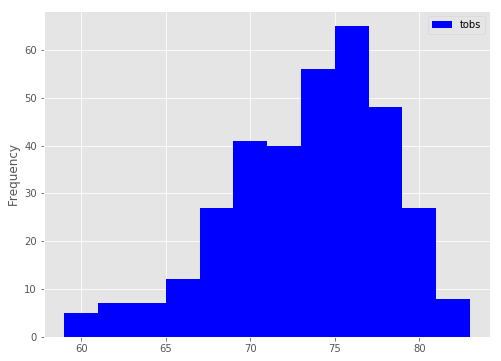

In [18]:
df.plot.hist(bins=12, figsize=(8,6), color='blue')
plt.show()

# Temperature Analysis

In [19]:
def calc_temps(start_date, end_date):
    # Build an expression to calculate the average of temperature labeled as temperature
    tobs_avg = func.avg(measurement.columns.tobs).label('tobs_avg')
    # Build a query to select the tobs
    stmt = select([tobs_avg])
    # filter By start_date
    stmt = stmt.where(measurement.columns.date > start_date)
    # filter by end_date
    stmt = stmt.where(measurement.columns.date < end_date)
    # group by date
    stmt = stmt.group_by(measurement.columns.date)
    # Execute the statement
    results = connection.execute(stmt).fetchall()
    # Create a DataFrame from the results: df
    df = pd.DataFrame(results)
    # Set column names
    df.columns = results[0].keys()
    # calcuations
    mean_tobs = df['tobs_avg'].mean()
    max_tobs = df['tobs_avg'].max()
    min_tobs = df['tobs_avg'].min()
    diff_tobs = max_tobs - min_tobs
    return df

In [20]:
df = calc_temps('2017-01-01', '2018-01-01')

In [21]:
mean_tobs = df['tobs_avg'].mean()
max_tobs = df['tobs_avg'].max()
min_tobs = df['tobs_avg'].min()
diff_tobs = max_tobs - min_tobs

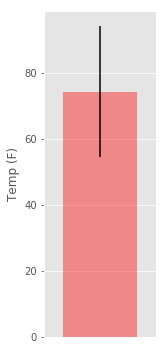

In [22]:
fig = plt.figure(figsize=(2,6))
plt.bar(0, mean_tobs, color='red', width=0.2, yerr = diff_tobs, alpha=0.4)
plt.xticks([])
plt.ylabel("Temp (F)")
plt.xlim(-0.15, 0.15)
plt.show()

# Optional Analysis

In [23]:
# define a function to calculate daily normals for a date (%m-%d)
def daily_normals(date):
    # Build expressions for temperature calculation
    tobs_avg = func.avg(measurement.columns.tobs).label('tobs_avg')
    tobs_max = func.max(measurement.columns.tobs).label('tobs_max')
    tobs_min = func.min(measurement.columns.tobs).label('tobs_min')
    # Build statement for query and filter with the date
    stmt = select([tobs_avg, tobs_max, tobs_min])
    stmt = stmt.where(measurement.columns.date.like(f"%{date}"))
    # Execute the statement
    results = connection.execute(stmt).fetchall()
    # assign values to variables
    mean, max, min = results[0]
    
    return mean, max, min

In [24]:
# generate date list with format of %m-%d
date_list = ["01-01", "01-02", "01-03", "01-04", "01-05", "01-06", "01-07"]

In [25]:
# generate empty lists
mean_list = []
max_list = []
min_list = []

# run the daily_mormals function and append values to lists
for date in date_list:
    mean, max, min = daily_normals(date)
    mean_list.append(mean)
    max_list.append(max)
    min_list.append(min)

In [26]:
# generate pandas data frame
df = pd.DataFrame({
    "date": date_list,
    "tavg": mean_list,
    "tmax": max_list,
    "tmin": min_list
})

In [27]:
# reset index of the data frame as date
df = df.set_index('date')

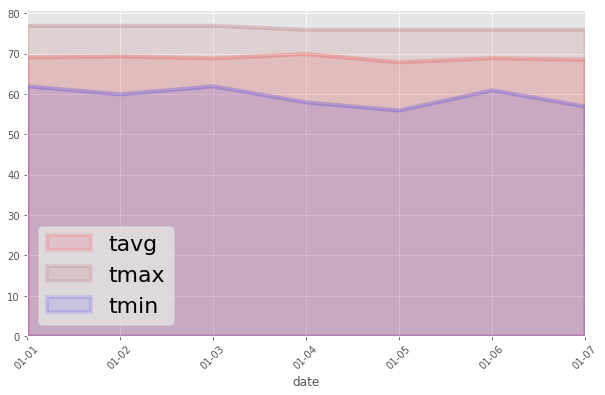

In [28]:
# generate area plot for visualization
df.plot.area(figsize=(10,6),stacked=False, alpha=0.1, linewidth=4,
             color=['red', 'brown','blue'])
plt.xticks(rotation=45)
plt.legend(fontsize = 22)
plt.show()